# Introduction  
**Project Overview**    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the genres of hip-hop and rap, Eminem is a rapper whose clever and technical delivery of provocative lyrics has made him famous among the general public and respected among his peers. While his crass and controversial word plays are notorious, Eminem also stands out as an artist whose lyrics offer a raw and unfiltered reflection of his personal experiences. My project explores both aspects by performing sentiment analysis on Eminem's discography within his albums and exploring patterns within his works, as well as investigating possible correlations between these sentiment scores and significant events in his personal life.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The primary focus of this project is to analyze the sentiment of Eminem's lyrics to uncover trends and patterns which may reflect significant elements in his personal journey. Specifically, two areas of focus will be explored:  
1. Are there any noticeable patterns in the sentiment scores within Eminem's albums?
2. What are the observable trends in sentiment scores across Eminem's albums, and in what ways do these trends correlate with events in his personal life?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The release of Eminem's newest album, *The Death of Slim Shady (Coup de Grâce)* catalyzed my interest in this topic. I have never been a huge Eminem fan, although I was aware of his hit tracks such as "Without Me" and "My Name Is." When I listened to his song "Temporary", which is a musical letter to his daughter when he is dead, I was introduced to the emotional intensity and autobiographical aspects of his work. By analyzing sentiment trends and investigating possible correlations between these sentiments, I hope to present nuances into how Eminem's journey has shaped his music. 

# Methods
**Focusing the Data**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To begin analyzing sentiment across Eminem's discography, the set of data first had to be determined. Three subsets were quickly eliminated:
1. Compilation albums, such as *Curtain Call: The Hits*, repeated songs present in previous albums and prioritized hits over a cohesive musical experience.
2. Deluxe editions of albums included extra tracks which typically did not make the original releases cut and might not reflect the intended thematic progression of the album. 
3. Singles were commonly either pre-releases before being added to the following album or collaborations with other artists whose own sentiment characteristics could distort the collected data. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This resulted in a collection size of 12 albums to analyze.

**Collecting the Data**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It quickly became apparent that Eminem's lyrics would need to be webscraped, as the many databases online created to store and present musical artist's lyrics only contained Eminem's first couple releases. Genius.com was selected, due to my personal favorable experience with the website and the vast lyrical library it contains. A custom webscraper was coded in Python, using the Python libraries *request* and *BeautifulSoup*.  After scraping the lyrics for every song, the data was organized into a nested dictionary, with the hierarchy of album_name --> song_name --> lyrics.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A major challenge was getting past the Genius.com's bot detection and coverage by Cloudflare. Midway through testing the scraper in the project's Jupyter server, my requests stopped working, encountering a 403 output. To get around this, I utilized Python's proxy library and rotated proxies using my PC's terminal. The data was then exported to the Git repository by saving the dictionary into the .txt file "lyrics_lines.txt" using Python's *json* library. 

In [1]:
import requests
from bs4 import BeautifulSoup
import json

# retrieve the link for every album's genius.com page
response = requests.get("https://genius.com/artists/albums?for_artist_page=45&id=Eminem")
html_string = response.text
document = BeautifulSoup(html_string, 'html.parser')
album_list = document.find_all("a", class_="album_link")   # <a class="album_link"> tags contain the html
#albums contains the desired album names
albums = ["The Slim Shady LP", "The Marshall Mathers LP", "The Eminem Show",
         "Encore", "Eminem Presents the Re-Up", "Relapse", "Recovery", "The Marshall Mathers LP 2",
         "Revival", "Kamikaze", "Music to Be Murdered By", "Music to Be Murdered By: Side B", 
          "The Death of Slim Shady (Coup De Grâce)"]
album_links = []
for a in album_list:
  if a.text in albums:                      # select desired albums from list
    album_links.append((a.text, a['href'])) # album links is (album name, link)


eminem_lyrics = {}
for album in album_links:          
  eminem_lyrics[album[0]] = {}     # key = album name, val = dictionary
  album_page = requests.get("https://genius.com" + album[1]) # go to album page
  album_html = album_page.text
  doc = BeautifulSoup(album_html, 'html.parser')
  songs_list = doc.find_all("div", class_="chart_row-content") # this tag's field contains the list of songs
  
  for s in songs_list:
    # <a href = song_link> song_name </a>
    a = s.find('a')
    s_title = a.find('h3').get_text(strip=True)
    eminem_lyrics[album[0]][s_title] = {}   # key = album_name -> song_name, val = dictionary
    
    s_link = a['href']
    # now use the link s_link to go to the song's lyrics page
    lyrics_page = requests.get(s_link)
    lyrics_html = lyrics_page.text
    d = BeautifulSoup(lyrics_html, 'html.parser')
    ly = d.find('div', class_="Lyrics__Container-sc-1ynbvzw-1 kUgSbL") # song's lyrics contained within this field 
    for br in ly.find_all('br'): 
      br.replace_with('\n')  # the 'br' tag denotes a new line in the raw html
    eminem_lyrics[album[0]][s_title]['lyrics'] = ly.text  # key = album_name -> song_name -> 'lyrics', val = string of lyrics

# named lyrics_lines_dud so that it does not overwrite lyrics_lines imported from my local system.
with open('lyrics_lines_dud.txt', 'w') as lyrics_file:  # export dictionary to .txt file
     lyrics_file.write(json.dumps(eminem_lyrics))

**Cleaning the Data**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Using *json*, the data was imported as a dictionary into the repository notebook. Before sentiment analysis could begin, the raw textual data required additional cleaning. Many of the scraped song names and lyrics contained non-ASCII characters. In addition, certain character sequences characteristic of html coding, such as "\\'" and 'xa0', needed to be replaced with their ASCII counterparts. While VADER, the sentiment analyzer chosen for this project, is capable of handling non-ASCII characters, its performance might not be optimal when handling them. In addition, structural indicators such as [Verse 1] and [Chorus], as well as noise descriptions such as \*camera flashes\*, needed to be removed in order to focus solely on lyrical content. Finally, excess white space and consecutive new lines were handled. The cleaning of the data was accomplished using 2 Python functions, one to use on the track titles and the other to clean the lyrical texts. 

In [2]:
import json
import re

with open('lyrics_lines.txt') as f:
  data = f.read()
# reconstructing the data as a dictionary 
raw_lyrics = json.loads(data) 

def clean_title(s):
  # replace non-breaking space (\xa0) with a regular space
  s = s.replace('\xa0', ' ')
    
  # reg expr to remove or replace other unwanted characters
  s = re.sub(r'[^\x00-\x7F]+', '', s)  # Removes non-ASCII characters
  return s
def clean_string(l):
  s = clean_title(l)
  
  # reg expr to get rid of all text enclosed by **
  s = re.sub(r'\*[^*]*\*', '', s)
  
  # reg expr to get rid of all text enclosed by []
  s = re.sub(r'\[[^\]]*\]', '', s)
  
  # remove extra white space while preserving new lines
  s = re.sub(r'[^\S\n]+', ' ', s) 
  
  # condense consecutive new lines into a single new line
  s = re.sub(r'\n+', '\n', s)
  
  # get rid of all instances of \'
  s = re.sub(r"\\'", "'", s)
  return s

# create an identical dictionary with the cleaned data
cleaned_lyrics = {}
for key, value in raw_lyrics.items():
  cleaned_lyrics[key] = {}
  for k, v in value.items():
    new_k = clean_title(k[:-6]) # clean song title
    cleaned_lyrics[key][new_k] = {}
    for a, b in v.items():
      new_lyrics = clean_string(b) # clean lyrics
      cleaned_lyrics[key][new_k][a] = new_lyrics


**Preparing The Data For Sentiment Analysis**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The sentiment analyzer used in this project is VADER (Valence Aware Dictionary and sEntiment Reasoner). Designed to handle social media texts, VADER is well-suited to analyze informal, conversational language which is similar to the language found in rap lyrics. Common among both is slang, abbreviations, casual expressions, and references to well-known figures. VADER also considers the context of the entire sentence or phrase. This is especially important for Eminem's lyrics, as context plays a key role in interpreting sentiment, especially where sentiment can shift as often as every line. VADER is also skilled in identifying negations and intensifiers of words ("very good" v.s. "not good" v.s. "good"), which is important as phrases in rap lyrics are often layered and complex.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;VADER does struggle with a few areas, which influenced how the lyrical texts were prepared. VADER is generally designed for short texts, analyzing sentiment on a sentence-by-sentence or phrase-by-phrase basis. In larger pieces of texts, the sentiment analyzer relies on punctuation to both divide the text into manageable chunks and help determine sentiment intensity. There are no sentence ending punctuation in the lyrical text, however, meaning clear phrase boundaries must be artifically introduced by breaking up the text before feeding it to the analyzer. Fortunately, Genius.com's lyrics already contain new lines which break songs up into bars. Using this separator, each text is broken up by phrase and stored as a list of strings, ready to be analyzed.

In [3]:
divided_lyrics = {}
for key, value in cleaned_lyrics.items():
  divided_lyrics[key] = {}  # add key (album title) to dictionary
  divided_lyrics[key]['a-sentiment'] = 0 # initialize int to hold album sentiment
  for k, v in value.items():
    divided_lyrics[key][k] = {}
    divided_lyrics[key][k]['s-sentiment'] = 0 #initialize int to hold song sentiment
    divided_lyrics[key][k]['hailie'] = False
    for a, b in v.items():
      substring = 'Hailie'
      if substring in b:
        divided_lyrics[key][k]['hailie'] = True
      split_lyrics = [line for line in b.split('\n') if line] # creates list of strings with '\n' as delimiter
      divided_lyrics[key][k][a] = split_lyrics

**Calculating Sentiment**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sentiment is calculated using a nested for loop. The sentiment analyzer is run on every phrase in a song, and then each compound score (the sentiment accounting for both positive and negative scores) is added together to form the song's sentiment score. The album's total sentiment score is then the sum of its track's sentiment scores. 

In [4]:
import nltk
from nltk.sentiment import vader
nltk.download('vader_lexicon')
nltk.download('stopwords')

# calculating total sentiment scores of songs and albums
sia = vader.SentimentIntensityAnalyzer()     # initialize sentiment analyzer
for album, tracks in divided_lyrics.items(): # key is album name, value dictionary including songs and sent score
  album_sentiment = 0                        # sentiment to be updated for each song
  for song, lines in tracks.items(): # song is keys under album, lines is dictionary
    song_sentiment = 0                       # sentiment to be updated for each phrase
    if isinstance(lines, dict): # if not a-sentiment
      for lyrics, l in lines.items(): # lyrics is keys under song
        if isinstance(l, list): # if not s-sentiment
          for bars in l:
            song_sentiment += sia.polarity_scores(bars)['compound'] # update song_sentiment
      divided_lyrics[album][song]['s-sentiment'] = song_sentiment
      album_sentiment += song_sentiment # update album_sentiment
  divided_lyrics[album]['a-sentiment'] = album_sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;However, this method fails to account for the varying album sizes and the different song lengths. A 4-minute song will naturally have a higher score than a 30-second intro song, just as an album with 18 tracks will be more likely to have a greater score than a 12-track album. While this correctly displays each song's sentiment strength, it distorts the songs' sentiment in relation to each other. Instead, averaging each song's sentiment by dividing the sum phrase sentiment by the number of phrases in each song will provide a more normalized view which mitigates any distortions due to varying line counts. Repeating this approach when calculating album sentiment scores will ensure that the differing album lengths also does not cause any distortions. 

In [5]:
# calculating average sentiment scores for songs and albums.
sia = vader.SentimentIntensityAnalyzer()
for album, tracks in divided_lyrics.items():
  album_size = 0                             # size of album initialized as zero
  album_sentiment = 0
  for song, lines in tracks.items(): 
    song_sentiment = 0
    if isinstance(lines, dict): 
      song_size = 0                          # size of song initialized as zero
      album_size += 1                        # increment album size for each song   
      for lyrics, l in lines.items(): 
        if isinstance(l, list):
          for bars in l:
            song_size += 1                   # increment song size for each line
            song_sentiment += sia.polarity_scores(bars)['compound']
      if song_size != 0:      # prevents dividing by zero for instrumental songs
        average_sent_score = song_sentiment / song_size # take the average
      divided_lyrics[album][song]['s-sentiment'] = average_sent_score
      album_sentiment += average_sent_score
  divided_lyrics[album]['a-sentiment'] = album_sentiment / album_size # take the average

# Results
### What trends in sentiment can be observed through Eminem's discography?
**Exploring the Data**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To showcase the evolution of sentiment across an album, inspiration was taken from the Romeo and Juliet assignment to use a colored bar graph to visualize how the sentiment evolves over time. Each bar chart displays the sentiment scores of the songs from the first track to the last. Any song with an average positive sentiment is colored yellow, while tracks with average negative sentiment are colored purple.


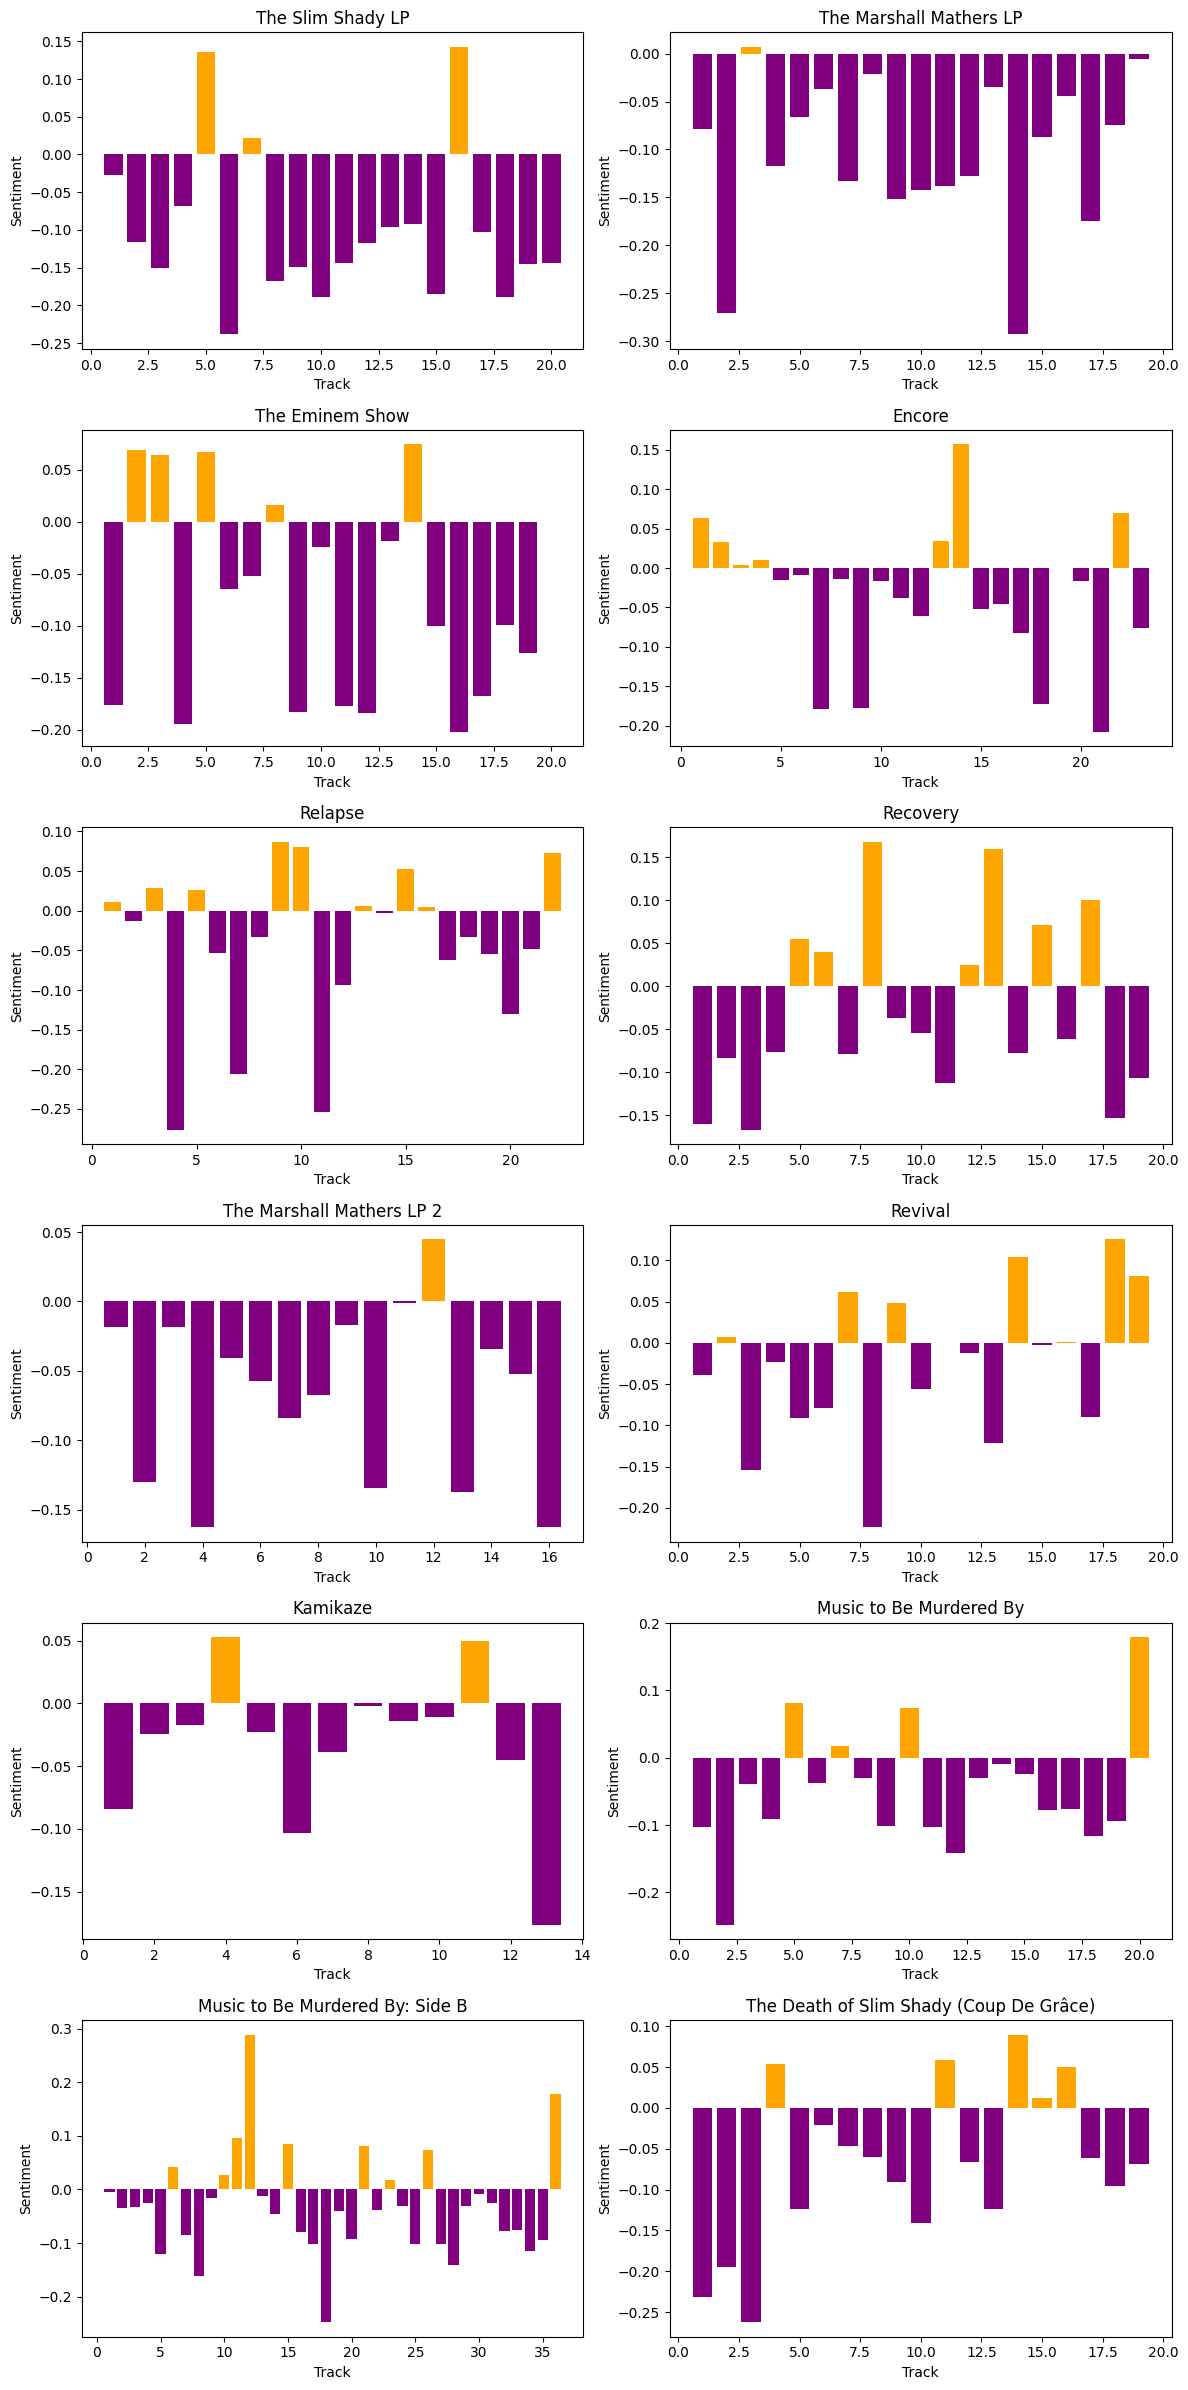

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# returns a list of list of tuples structured [(album, [(song, score)])]
def plot_sentiment_songs(album_dict):
  album_scores = []
  for key, value in album_dict.items(): # value is dictionary under album
    song_scores = []
    for k, v in value.items():
      if isinstance(v, dict):
        for a, b in v.items():
          if isinstance(b, float):
            song_scores.append((k, b))
    album_scores.append((key, song_scores))
  return album_scores

album_plot = plot_sentiment_songs(divided_lyrics)
release_order = [9, 0, 6, 4, 7, 2, 1, 11, 5, 10, 8, 12]
data_set = []
for i in release_order:
  data_set.append(album_plot[i])

def sentiment_charter(t):
  fig, axs = plt.subplots(6, 2, figsize=(12, 24))
  axs = axs.flatten()
  
  for i in range(12): # a is album
    a = t[i]
    album = a[0]
    song_name, sent_score = zip(*a[1])
    track_numbers = list(range(1, len(sent_score) + 1))
    colors = ['orange' if score >= 0 else 'purple' for score in sent_score]
    
    axs[i].bar(track_numbers, sent_score, color=colors)
    axs[i].set_title(album)
    axs[i].set_xlabel('Track')
    axs[i].set_ylabel('Sentiment')
  plt.tight_layout()
    
sentiment_charter(data_set)

**Analyzing the Data**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the visualization above, the sentiment scores across each album is displayed from oldest to newest release. Observably, no album contains more positive sentiment scores than negative scores, signifying that Eminem's discography favors negative emotional intensity. It is not a close contest either: his songs appear to convey overwhelming negative emotions. 

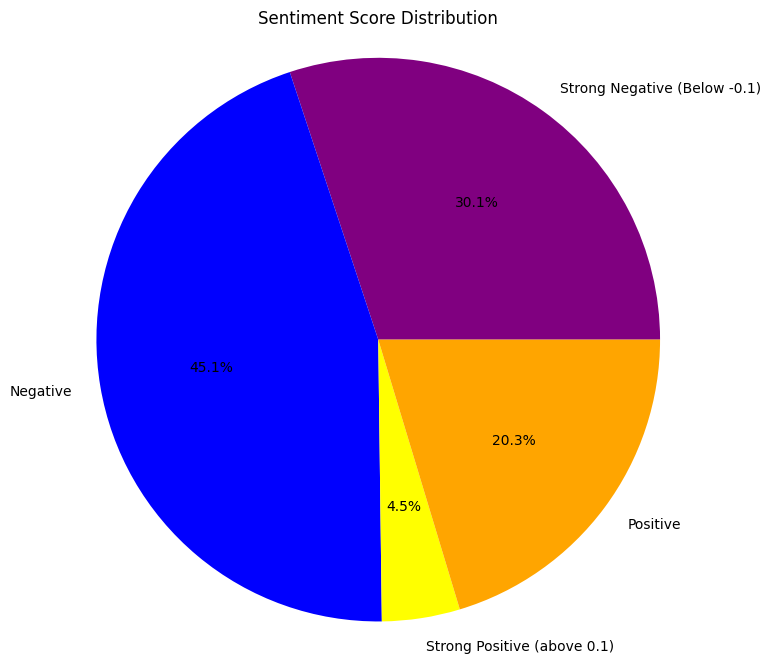

In [7]:
# pie chart
very_neg = 0
very_pos = 0
pos = 0
neg = 0

all_scores = []
for a in data_set:
  sent_scores = [item[1] for item in a[1]]
  all_scores += sent_scores
for s in all_scores:
  if s <= -.1:
    very_neg += 1
  elif s > -.1 and s <= 0:
    neg += 1
  elif s < .1 and s > 0:
    pos += 1
  elif s >= .1:
    very_pos += 1

categories = ['Strong Negative (Below -0.1)', 'Negative', 'Strong Positive (above 0.1)', 'Positive']
values = [very_neg, neg, very_pos, pos]
colors = ['purple', 'blue', 'yellow', 'orange']
fig, ax = plt.subplots(figsize=(8, 8))  # You can adjust the size as needed
ax.pie(values, labels=categories, autopct='%1.1f%%', colors=colors)

# Set the aspect ratio to be equal to ensure the pie is drawn as a circle
ax.axis('equal')

# Add a title
plt.title('Sentiment Score Distribution')

plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This trend towards more negative emotion is represented in the pie chart above. 75.2% of Eminem's songs have negative sentiments, with 40% of them carrying a strong negative sentiment score of -0.1 or below. By contrast, only 24.8% of Eminem's songs are positive and only 18.1% of these convey a postive sentiment stronger than 0.1. Not only is the frequency of songs with negative sentiment greater than those with positive sentiments, but negative scores are more likely to be strong than positive scores. Additionally, by observing the peaks of the bar charts above, the strongest negative sentiment appears to almost always surpass the strongest positive sentiment. 

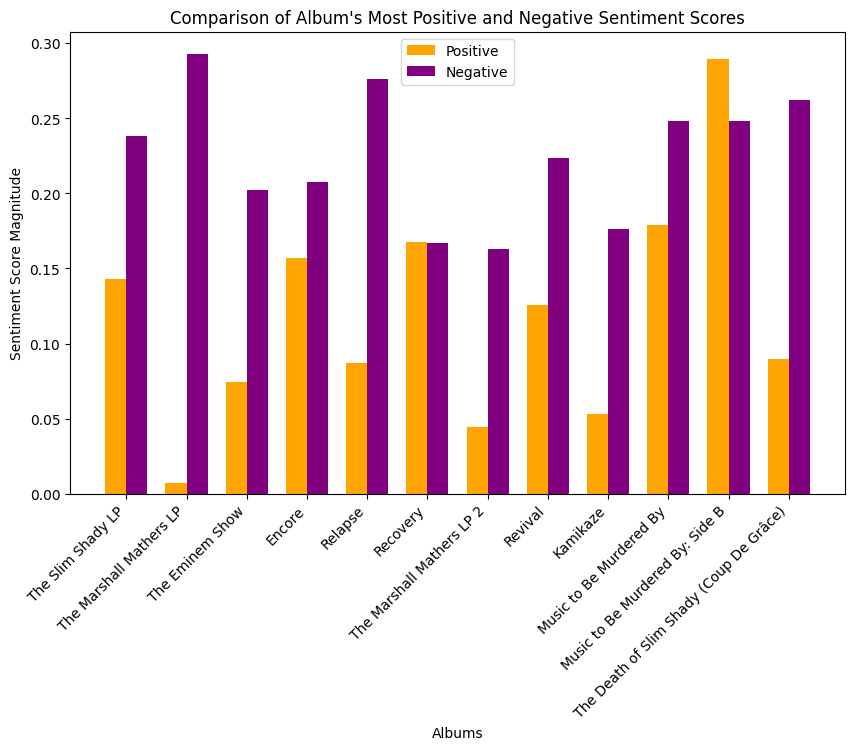

In [8]:
album_names = []
pos_scores = []
neg_scores = []
for a in data_set:
  album_names.append(a[0])
  sent_scores = [item[1] for item in a[1]]
  pos_scores.append(max(sent_scores))
  neg_scores.append(abs(min(sent_scores)))
  
num_alb = 12
x = np.arange(num_alb)  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bars1 = ax.bar(x - width/2, pos_scores, width, label='Positive', color='orange')
bars2 = ax.bar(x + width/2, neg_scores, width, label='Negative', color='purple')
ax.set_xlabel('Albums')
ax.set_ylabel('Sentiment Score Magnitude')
ax.set_title("Comparison of Album's Most Positive and Negative Sentiment Scores")
ax.set_xticks(x)
ax.set_xticklabels(album_names, rotation=45, ha='right')          
ax.legend()
plt.show()



&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The above bar chart supports this observation, revealing only two albums - *Recovery* and *Music to Be Murdered By: Side B* - where the strongest positive score is greater than the strongest negative score. There is also a noticeable gap of at least 0.05 points between the positive and negative scores in his albums, with nearly half of these gaps being greater than 0.1.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This suggests a broader trend in Eminem's music towards expressing and exploring themes of adversity, struggle, and emotional intensity. The dominance of negative sentiment across his work may reflect personal and artistic inclinations, providing a deeper insight into the emotional landscape of his discography.

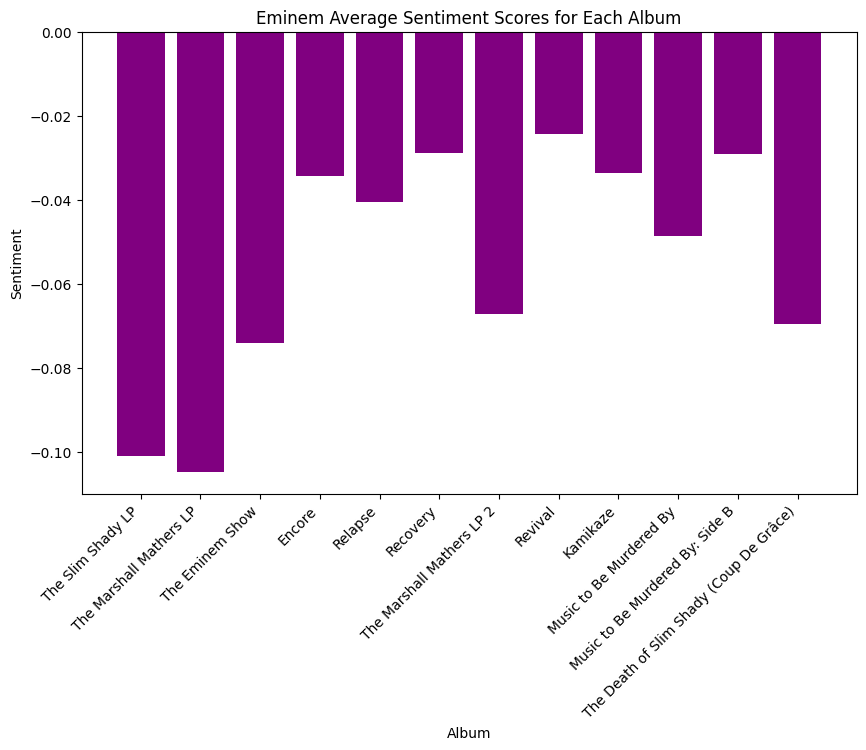

In [9]:
def plot_album_sentiment(d):
  album_sent = []
  for key, value in d.items():
    for k, v in value.items():
      if isinstance(v, float):  # each sentiment score
        album_sent.append((key, v))
  # list containing album order of release, not including the Re-Up, as it is a compilation album I just found out
  release_order = [9, 0, 6, 4, 7, 2, 1, 11, 5, 10, 8, 12]
  album_plot = []
  for i in release_order:
    album_plot.append(album_sent[i])
  album_names = [t[0] for t in album_plot]
  sent_score = [t[1] for t in album_plot]
  
  colors = ['orange' if score >= 0 else 'purple' for score in sent_score]
  plt.figure(figsize=(10, 6))
  plt.bar(album_names, sent_score, color=colors) # changed from song name to track number, as names were too long
  plt.title('Eminem Average Sentiment Scores for Each Album')
  plt.xlabel('Album')
  plt.ylabel('Sentiment')
  plt.xticks(rotation=45, ha='right')
plot_album_sentiment(divided_lyrics)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dominance of negative sentiment across his works is also represented in the sentiment scores of his albums. No album, as presented above, has an overall positive sentiment. The albums with the strongest negative sentiment are his first three albums, while both *The Marshall Mathers LP 2* and *The Death of Slim Shady (Coup De Grace)* are outliers for their strong negative sentiment's in his later works.  

### How do these trends in sentiment reflect Eminem's identity?
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Central to Eminem's identity is his two personas. Eminem is his name as the rapper. He has an alter-ego called Slim Shady, who is behind some of Eminem's angriest and most controversial songs. Raunchy, graphic, and explicit language are characteristic of this persona. This persona was most prominent in his first three albums[^1], which is reflected by the fact that these three hold the strongest negative sentiment. Eminem's more mature and vulnerable persona is Marshall Mathers, which is his birthname.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Interestingly, the five albums with the strongest negative sentiment, as well as being the only albums with a sentiment below -0.05, are also the five albums which contain one of his three personas ('Slim Shady', 'Marshall Mathers', 'Eminem') in the album title. 

[^1]: [americansongwriter.com](https://americansongwriter.com/marshall-mathers-vs-slim-shady-a-look-at-eminems-two-personas/)

**Word Choice**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A key element of rap music is how explicit, graphic, and raunchy its language often is. As one of the most controversial rappers, Eminem is no exception to this. 
Next, plot the albums as a bar chart. Notice that his most negative 3 albums were his first 3. 
Next, plot the albums as a bar chart again but with a noticeable bell curve. Also notice that his ascent into postive sentiment coincides with him before and after recovery. I can redo this bar chart in the DISCUSSION section with color to clearly differentiate them. 

In [10]:
# top 10 most common positive and negative words in Eminem's albums
import string
from string import punctuation
from nltk.corpus import stopwords
myStopWords = list(punctuation) + stopwords.words('english')

def words_dict(d):
  new_dict = {}
  for key, value in d.items(): # value is dict containing songs
    if key != 'Eminem Presents the Re-Up':
      new_dict[key] = {}
      if isinstance(value, dict):
        for k, v in value.items(): # k is song name, want v to be a dict
          if isinstance(v, dict):
            lyrics = " ".join(v['lyrics'])
            all_words = lyrics.split()
            lower_words = [word.strip(string.punctuation).lower() for word in all_words]
            new_dict[key][k] = [w for w in lower_words if w not in myStopWords]
  return new_dict

word_lyrics = words_dict(divided_lyrics)

In [50]:
# returns a tuple containing all most common positive and negative words for each album
# tuple of 2 lists, each list contains a tuple which contains a string and list, with that list containing tuple of 
# common words
def album_common_sentiment(d):
  new_dict = {}
  
  com_pos = []
  com_neg = []
  for album, songs in d.items():
    all_lyrics = []
    for key, lyrics in songs.items(): # add all words from songs to album lyrics
      all_lyrics += lyrics
    positive = []
    negative = []
    for word in all_lyrics:
      word_score = sia.polarity_scores(word)
      if word_score['compound'] > 0:
        positive.append(word)
      elif word_score['compound'] < 0:
        negative.append(word)
    common_positive = nltk.FreqDist(positive).most_common(10)
    common_negative = nltk.FreqDist(negative).most_common(10)
    com_pos.append((album, common_positive))
    com_neg.append((album, common_negative))
  return (com_pos, com_neg)

print(album_common_sentiment(word_lyrics))
    

([('The Marshall Mathers LP', [('like', 34), ('yeah', 16), ('please', 8), ('want', 6), ('better', 4), ('good', 3), ('okay', 3), ('love', 3), ('well', 3), ('kiss', 2)]), ('The Marshall Mathers LP 2', [('like', 35), ('yeah', 14), ('please', 6), ('well', 5), ('better', 3), ('straight', 3), ('love', 3), ('fine', 2), ('kidding', 2), ('excuse', 2)]), ('Recovery', [('like', 58), ('yeah', 26), ('love', 21), ('better', 12), ('well', 9), ('want', 6), ('good', 6), ('woo', 5), ('god', 4), ('haha', 4)]), ('Encore', [('like', 38), ('yeah', 11), ('love', 11), ('want', 7), ('good', 6), ('god', 6), ('please', 5), ('well', 5), ('definitely', 5), ('okay', 4)]), ('Kamikaze', [('yeah', 51), ('like', 50), ('woo', 14), ('want', 6), ('hope', 6), ('nice', 5), ('better', 4), ('god', 4), ('straight', 3), ('welcome', 3)]), ('The Eminem Show', [('like', 26), ('want', 12), ('yeah', 8), ('good', 7), ('love', 5), ('ha', 4), ('kiss', 4), ('straight', 3), ('god', 3), ('well', 3)]), ('Relapse', [('yeah', 34), ('like', 2

In [ ]:
# count the references to 'slim' and 'shady'
family_words = [
    'father', 'mother', 'brother', 'sister', 'uncle', 'aunt',
    'cousin', 'nephew', 'niece', 'grandfather', 'grandmother',
    'parent', 'child', 'spouse', 'husband', 'wife', 'home', 'house',
  'daddy', 'dad', 'mommy', 'mom', 'hailie', 'debbie', 'kim', 'baby'
]
for f in family_words:
  family_words.append(f + "'s'")
shady_ref = []
for album, songs in word_lyrics.items():
    slim_shady = 0
    all_lyrics = []
    for key, lyrics in songs.items(): # add all words from songs to album lyrics
      all_lyrics += lyrics
    for word in all_lyrics:
      if word == 'slim' or word == 'shady' or word == "shady's" or word == "marshall":
        slim_shady += 1
    shady_ref.append((album, slim_shady))

family_ref = []
for album, songs in word_lyrics.items():
    fam = 0
    all_lyrics = []
    for key, lyrics in songs.items(): # add all words from songs to album lyrics
      all_lyrics += lyrics
    for word in all_lyrics:
      if word in family_words:
        fam += 1
    family_ref.append((album, fam))
print(shady_ref)
print(family_ref)

In [ ]:
  axs = axs.flatten()
  
  for i in range(13): # a is album
    a = t[i]
    album = a[0]
    song_name, sent_score = zip(*a[1])
    track_numbers = list(range(1, len(sent_score) + 1))
    colors = ['orange' if score >= 0 else 'purple' for score in sent_score]
    
    axs[i].bar(track_numbers, sent_score, color=colors)
    axs[i].set_title(album)
    axs[i].set_xticks(track_numbers)
    axs[i].set_xlabel('Track')
    axs[i].set_ylabel('Sentiment')
  fig.delaxes(axs[13])
  plt.tight_layout()